In [1]:
import json
from json import dump, dumps, load
import requests
import copy
import zlib

from copy import deepcopy
import os
import logging
import datetime
from datetime import date
import sys

import numpy as np
import pandas as pd
from csv import DictWriter
from csv import writer

from collections import OrderedDict
import networkx as nx
import spotpy

from urllib.error import HTTPError
from urllib.parse import urlencode
from urllib.request import Request, urlopen

In [2]:
base_url = "https://estmodel.envir.ee"

stations_api = "/stations"

stations_params = {'code': '', 'name': '', 'offset': 0, 'limit':18, 'type':'hydrochemical'}

In [3]:
station_codes = []

p=copy.copy(stations_params)
p.update({'limit': 60})

r = requests.get(base_url + stations_api, params=p)

In [4]:
r.status_code

200

In [5]:
import pandas as pd

In [6]:
df = pd.DataFrame(r.json()).set_index("code")
df

,name,area
code,,
SJA0664000,Ahja jõgi: Kiidjärve,331.244100
SJA7675000,Ahja jõgi: Lääniste sild,941.413800
SJA8127000,Alajõgi: Griini (Alajõe),140.663100
SJA8211000,Avijõgi: Mulgi,400.496400
SJA8007000,Emajõgi: Kavastu,8534.484492
SJA2302000,Emajõgi: Rannu-Jõesuu,3408.839396
SJA7982000,Emajõgi: Tartu (Kvissental),7844.152896
SJA6180000,Jägala jõgi: Jägala juga,1570.000000
SJA8358000,Jänijõgi: Jäneda,39.655400


In [8]:
model_for_station_api = "/stations/{}/models".format

stations_params = {'start-year': 2019, 'end-year': 2019}

In [ ]:
for idx, row in df.iterrows():
    r = requests.get(base_url + model_for_station_api(idx), params=stations_params)
    print(f"{idx} - {r.status_code}")

    # Test writing a JSON string to file
    with open('data/{}_response.json'.format(idx), 'w', encoding='utf-8') as file:
        json_string = json.dumps(r.json(), ensure_ascii=False, indent=4)
        file.write(json_string)

In [7]:
def get_sub_structures(upper_root_subs, level, G, incoming_root_def):
    return_dicts = []
    level = level + 1
    for model_x in upper_root_subs:
        
        code = model_x['code']
        name = model_x['name']
        root_def = f"{code}__{name}"
        
        this_structure = OrderedDict({ 'level': level, root_def: []})
        G.add_node(root_def)
        
        
        if "subcatchments" in model_x.keys():
            root_subs = model_x["subcatchments"]
            sub_catchments = get_sub_structures(root_subs, level, G, incoming_root_def)
            for sd in sub_catchments:
                this_structure[root_def].append(sd)
                target = list(filter(lambda x: x not in 'level' and '_G' not in x, sd.keys()))[0]
                G.add_edge(target, root_def)
        else:
            G.add_edge(root_def, incoming_root_def)

        return_dicts.append(this_structure)
    return return_dicts

structure = OrderedDict()

for idx, row in df.iterrows():
    with open('data/{}_response.json'.format(idx), 'r', encoding='utf-8') as file:
        json_data = json.load(file)
        
        if len(json_data) == 1:
            model_x = json_data[0]
            code = model_x['code']
            name = model_x['name']
            year = model_x['year']
            
            level = 0
            root_def = f"{code}__{name}__{year}"
            G = nx.DiGraph()
            structure.update({ 'level': level, root_def: [] , root_def + '_G' : G})
            
            G.add_node(root_def)
            
            if "subcatchments" in model_x.keys():
                root_subs = model_x["subcatchments"]
                sub_catchments = get_sub_structures(root_subs, level, G, root_def)
                for sd in sub_catchments:
                    structure[root_def].append(sd)
                    target = list(filter(lambda x: x not in 'level' and '_G' not in x, sd.keys()))[0]
                    G.add_edge(target, root_def)

        else:
            print(f"{idx} not normal?")
            print(f"{len(json_data)}")


In [72]:
# structure

In [73]:
# list(filter(lambda x: "_G" in x, structure.keys()))

In [8]:
structure['SJA8007000__Emajõgi: Kavastu__2019']

[OrderedDict([('level', 1),
              ('SJA8007000__Emajõgi: Kavastu',
               [OrderedDict([('level', 2),
                             ('SJA3124000__Porijõgi: Reola – Vana-Kuuste tee (Uhti)',
                              [])]),
                OrderedDict([('level', 2),
                             ('SJA7982000__Emajõgi: Tartu (Kvissental)',
                              [OrderedDict([('level', 3),
                                            ('SJA0106000__Võisiku pkr: enne Võisiku paisjärve',
                                             [])]),
                               OrderedDict([('level', 3),
                                            ('SJA7946000__Põltsamaa jõgi: Rutikvere',
                                             [OrderedDict([('level', 4),
                                                           ('SJA2802000__Oostriku jõgi: Oostriku',
                                                            [])]),
                                              OrderedD

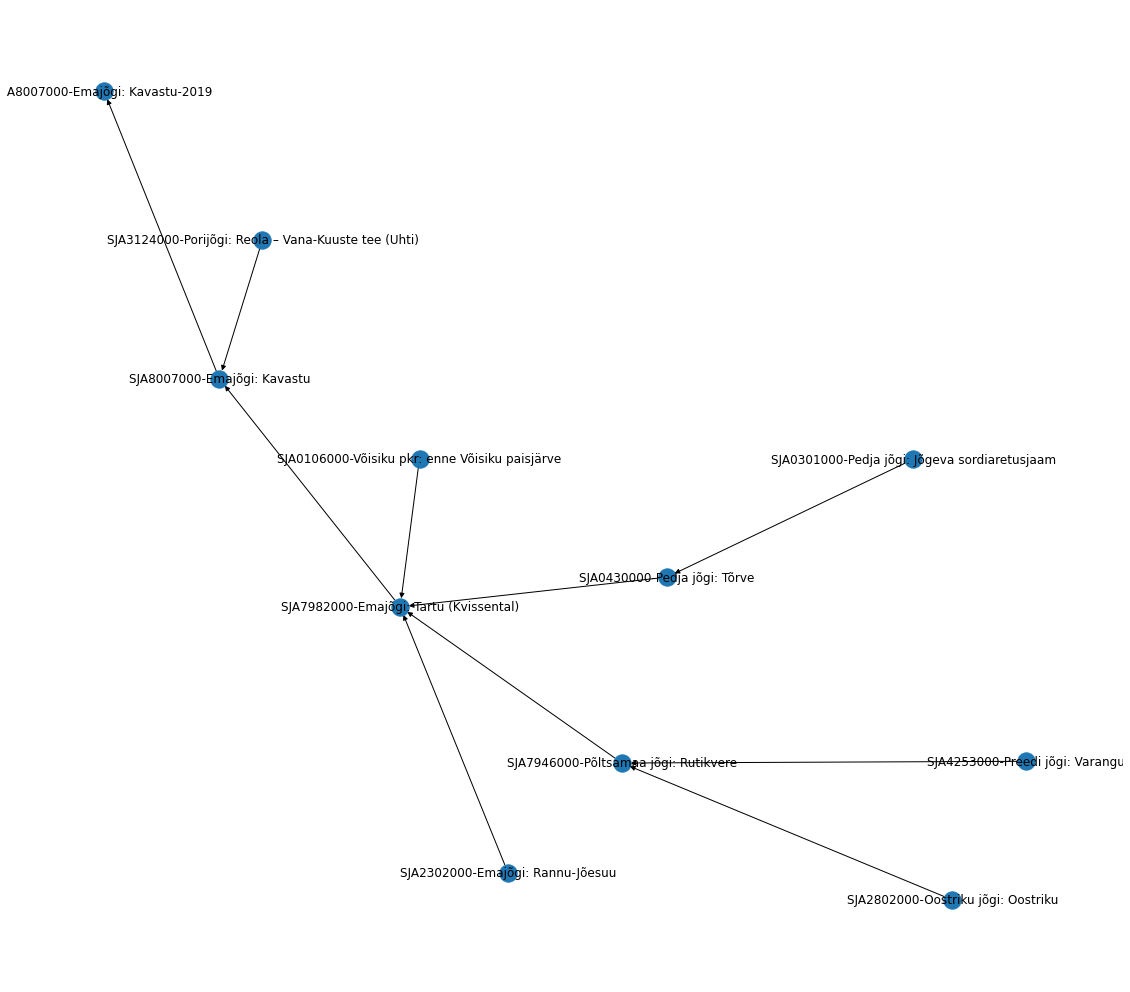

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 18))
nx.draw(structure['SJA8007000__Emajõgi: Kavastu__2019_G'], with_labels=True)

In [ ]:
for g in list(filter(lambda x: '_G' in x, structure.keys())):

    fig, ax = plt.subplots(figsize=(20, 18))
    nx.draw(structure[g], with_labels=True)
    plt.title(g)
    plt.show()

In [9]:
from csv import writer
from datetime import date
from json import dump, dumps, load

from urllib.error import HTTPError
from urllib.parse import urlencode
from urllib.request import Request, urlopen

PARAMETERS = {
    "AOX": "Adsorbable organic halides",
    "BOD5": "5 day biochemical oxygen demand",
    "BOD7": "7 day biochemical oxygen demand",
    "CD": "Cadmium",
    "COD-CR": "Chemical oxygen demand (Cr)",
    "COD-MN": "Chemical oxygen demand (KMnO4)",
    "CR": "Chromium",
    "CU": "Copper",
    "HG": "Mercury",
    "NH4-N": "Ammonium nitrogen",
    "NI": "Nickel",
    "NO2-N": "Nitrite nitrogen",
    "NO23-N": "Nitrite nitrogen and nitrate nitrogen",
    "NO3-N": "Nitrate nitrogen",
    "OIL": "Oil",
    "PB": "Lead",
    "PO4-P": "Phosphate",
    "Q": "Flow",
    "SS": "Suspended solids",
    "TN": "Total nitrogen",
    "TOC": "Total organic carbon",
    "TP": "Total phosphorus",
    "ZN": "Zinc"
}

SERVICE_BASE_HREF = "https://estmodel.envir.ee"

SOURCES = {
    "arableland": "Arable lands",
    "forest": "Forests",
    "pasture": "Pastures",
    "peatland": "Peatlands",
    "point": "Point sources",
    "water": "Water surfaces",
    "wetland": "Wetlands",
    "other": "Other"
}

def find_subcatchments(object):
    subcatchments = [object] if "year" not in object else []
    for sc in object["subcatchments"]:
        subcatchments.extend(find_subcatchments(sc))
    return subcatchments


def find(*path, **qparams):
    url = SERVICE_BASE_HREF + "/" + "/".join(path)
    if qparams:
        qparams = {p.replace("_", "-"): v for p, v in qparams.items()}
        url += "?" + urlencode(qparams)
    try:
        with urlopen(Request(url, headers={"Accept": "application/json"})) as response:
            results = load(response)
            if path[-1].endswith("estimates") or path[-1].endswith("measurements"):
                for result in results:
                    result["date"] = date.fromisoformat(result["date"])
                    result["parameter"] = result["parameter"].upper()
            return results
    except HTTPError as error:
        if error.code == 400:
            raise HTTPError(error.filename, error.code, error.read()
                            .decode("utf-8"), error.headers, error.fp) from None
        else:
            raise error


def run(estmodel):
    try:
        with urlopen(Request(SERVICE_BASE_HREF,
                             method="POST",
                             data=dumps(estmodel).encode("utf-8"),
                             headers={"Content-Type": "application/json"})) as response:
            return load(response)
    except HTTPError as error:
        if error.code == 400:
            raise HTTPError(error.filename, error.code, error.read()
                            .decode("utf-8"), error.headers, error.fp) from None
        else:
            raise error


def sumattr(object, name, parameter=None):
    result = 0.0
    if name in object:
        return object[name]
    elif "year" in object:
        for sc in find_subcatchments(object):
            result += sumattr(sc, name, parameter)
    elif name == "discharge":
        for m in object["measurements"]:
            if m["parameter"] == parameter:
                result += m[name]
    elif name == "factor":
        for a in object["adjustments"]:
            if a["parameter"] == parameter:
                result *= a[name]
    elif "subcatchments" in object:
        for ds in object["diffuseSources"]:
            result += sumattr(ds, name, parameter)
        for ps in object["pointSources"]:
            result += sumattr(ps, name, parameter)
    elif name in ["anthropogenicDischarge", "atmosphericDeposition", "naturalDischarge", "retention"]:
        for e in object["estimates"]:
            if e["parameter"] == parameter:
                result += e[name]
    elif name == "amount":
        for f in object.get("fertilizers", []):
            if f["parameter"] == parameter:
                result += f[name]
    return result


In [10]:
def prep_csv_output(model, temp_dir="."):
    rows = []
    # print(model["code"], model["name"])
    model2 = deepcopy(model)
    for sc in find_subcatchments(model2):
        sc["adjustments"] = []
        sc["measurements"] = []
    model2 = run(model2)
    rows.append({
        "year": model["year"],
        "type": "catchment",
        "c_code": model["code"],
        "c_name": model["name"],
        "area": sumattr(model, "area"),
        "flow_q": sum(sc["waterDischarge"] for sc in model["subcatchments"]),
        "drained_area": sumattr(model, "drainedArea"),
        "harvested_area": sumattr(model, "harvestedArea"),
        "clay_soil_area": sumattr(model, "claySoilArea"),
        "fertile_soil_area": sumattr(model, "fertileSoilArea"),
        "peat_soil_area": sumattr(model, "peatSoilArea"),
        "scattered_population": sumattr(model, "scatteredPopulation"),
        "tn_fertilizer_amount": sumattr(model, "amount", "tn"),
        "tp_fertilizer_amount": sumattr(model, "amount", "tp"),
        "tn_anthropogenic_unadjusted_estimate": sumattr(model2, "anthropogenicDischarge", "tn"),
        "tn_atmospheric_unadjusted_estimate": sumattr(model2, "atmosphericDeposition", "tn"),
        "tn_natural_unadjusted_estimate": sumattr(model2, "naturalDischarge", "tn"),
        "tn_unadjusted_retention": sumattr(model2, "retention", "tn"),
        "tn_anthropogenic_estimate": sumattr(model, "anthropogenicDischarge", "tn"),
        "tn_atmospheric_estimate": sumattr(model, "atmosphericDeposition", "tn"),
        "tn_natural_estimate": sumattr(model, "naturalDischarge", "tn"),
        "tn_retention": sumattr(model, "retention", "tn"),
        "tp_anthropogenic_unadjusted_estimate": sumattr(model2, "anthropogenicDischarge", "tp"),
        "tp_atmospheric_unadjusted_estimate": sumattr(model2, "atmosphericDeposition", "tp"),
        "tp_natural_unadjusted_estimate": sumattr(model2, "naturalDischarge", "tp"),
        "tp_unadjusted_retention": sumattr(model2, "retention", "tp"),
        "tp_anthropogenic_estimate": sumattr(model, "anthropogenicDischarge", "tp"),
        "tp_atmospheric_estimate": sumattr(model, "atmosphericDeposition", "tp"),
        "tp_natural_estimate": sumattr(model, "naturalDischarge", "tp"),
        "tp_retention": sumattr(model, "retention", "tp")
    })
    for sc, sc2 in zip(find_subcatchments(model), find_subcatchments(model2)):
        sc_area = sumattr(sc, "area")
        sc_flow_q = (sc["waterDischarge"] - sum(ssc["waterDischarge"]
                     for ssc in sc["subcatchments"]))
        rows.append({
            "year": model["year"],
            "type": "subcatchment",
            "c_code": model["code"],
            "c_name": model["name"],
            "sc_code": sc["code"],
            "sc_name": sc["name"],
            "area": sc_area,
            "distance": sc["distance"],
            "depth": sc["waterDepth"],
            "flow_q": sc_flow_q,
            "flow_v": sc["flowVelocity"],
            "tn_measurement": sumattr(sc, "discharge", "tn") or None,
            "tp_measurement": sumattr(sc, "discharge", "tp") or None,
            "drained_area": sumattr(sc, "drainedArea"),
            "harvested_area": sumattr(sc, "harvestedArea"),
            "clay_soil_area": sumattr(sc, "claySoilArea"),
            "fertile_soil_area": sumattr(sc, "fertileSoilArea"),
            "peat_soil_area": sumattr(sc, "peatSoilArea"),
            "scattered_population": sumattr(sc, "scatteredPopulation"),
            "tn_fertilizer_amount": sumattr(sc, "amount", "tn"),
            "tp_fertilizer_amount": sumattr(sc, "amount", "tp"),
            "tn_anthropogenic_unadjusted_estimate": sumattr(sc2, "anthropogenicDischarge", "tn"),
            "tn_atmospheric_unadjusted_estimate": sumattr(sc2, "atmosphericDeposition", "tn"),
            "tn_natural_unadjusted_estimate": sumattr(sc2, "naturalDischarge", "tn"),
            "tn_unadjusted_retention": sumattr(sc2, "retention", "tn"),
            "tn_anthropogenic_estimate": sumattr(sc, "anthropogenicDischarge", "tn"),
            "tn_atmospheric_estimate": sumattr(sc, "atmosphericDeposition", "tn"),
            "tn_natural_estimate": sumattr(sc, "naturalDischarge", "tn"),
            "tn_retention": sumattr(sc, "retention", "tn"),
            "tp_anthropogenic_unadjusted_estimate": sumattr(sc2, "anthropogenicDischarge", "tp"),
            "tp_atmospheric_unadjusted_estimate": sumattr(sc2, "atmosphericDeposition", "tp"),
            "tp_natural_unadjusted_estimate": sumattr(sc2, "naturalDischarge", "tp"),
            "tp_unadjusted_retention": sumattr(sc2, "retention", "tp"),
            "tp_anthropogenic_estimate": sumattr(sc, "anthropogenicDischarge", "tp"),
            "tp_atmospheric_estimate": sumattr(sc, "atmosphericDeposition", "tp"),
            "tp_natural_estimate": sumattr(sc, "naturalDischarge", "tp"),
            "tp_retention": sumattr(sc, "retention", "tp")
        })
        for ds, ds2 in zip(sc["diffuseSources"], sc2["diffuseSources"]):
            rows.append({
                "year": model["year"],
                "type": ds["type"] or "other",
                "c_code": model["code"],
                "c_name": model["name"],
                "sc_code": sc["code"],
                "sc_name": sc["name"],
                "area": ds["area"],
                "distance": sc["distance"],
                "depth": sc["waterDepth"],
                "flow_q": sc_flow_q / sc_area * ds["area"],
                "flow_v": sc["flowVelocity"],
                "drained_area": ds["drainedArea"],
                "harvested_area": ds["harvestedArea"],
                "clay_soil_area": ds["claySoilArea"],
                "fertile_soil_area": ds["fertileSoilArea"],
                "peat_soil_area": ds["peatSoilArea"],
                "scattered_population": ds["scatteredPopulation"],
                "tn_fertilizer_amount": sumattr(ds, "amount", "tn"),
                "tp_fertilizer_amount": sumattr(ds, "amount", "tp"),
                "tn_anthropogenic_unadjusted_estimate": sumattr(ds2, "anthropogenicDischarge", "tn"),
                "tn_atmospheric_unadjusted_estimate": sumattr(ds2, "atmosphericDeposition", "tn"),
                "tn_natural_unadjusted_estimate": sumattr(ds2, "naturalDischarge", "tn"),
                "tn_unadjusted_retention": sumattr(ds2, "retention", "tn"),
                "tn_anthropogenic_estimate": sumattr(ds, "anthropogenicDischarge", "tn"),
                "tn_atmospheric_estimate": sumattr(ds, "atmosphericDeposition", "tn"),
                "tn_natural_estimate": sumattr(ds, "naturalDischarge", "tn"),
                "tn_retention": sumattr(ds, "retention", "tn"),
                "tp_anthropogenic_unadjusted_estimate": sumattr(ds2, "anthropogenicDischarge", "tp"),
                "tp_atmospheric_unadjusted_estimate": sumattr(ds2, "atmosphericDeposition", "tp"),
                "tp_natural_unadjusted_estimate": sumattr(ds2, "naturalDischarge", "tp"),
                "tp_unadjusted_retention": sumattr(ds2, "retention", "tp"),
                "tp_anthropogenic_estimate": sumattr(ds, "anthropogenicDischarge", "tp"),
                "tp_atmospheric_estimate": sumattr(ds, "atmosphericDeposition", "tp"),
                "tp_natural_estimate": sumattr(ds, "naturalDischarge", "tp"),
                "tp_retention": sumattr(ds, "retention", "tp")
            })
        for ps, ps2 in zip(sc["pointSources"], sc2["pointSources"]):
            rows.append({
                "year": model["year"],
                "type": "point",
                "c_code": model["code"],
                "c_name": model["name"],
                "sc_code": sc["code"],
                "sc_name": sc["name"],
                "s_code": ps["code"],
                "s_name": ps["name"],
                "distance": ps["distance"],
                "depth": sc["waterDepth"],
                "flow_q": ps["waterDischarge"],
                "flow_v": sc["flowVelocity"],
                "tn_measurement": sumattr(ps, "discharge", "tn") or None,
                "tp_measurement": sumattr(ps, "discharge", "tp") or None,
                "tn_anthropogenic_unadjusted_estimate": sumattr(ps2, "anthropogenicDischarge", "tn"),
                "tn_atmospheric_unadjusted_estimate": sumattr(ps2, "atmosphericDeposition", "tn"),
                "tn_natural_unadjusted_estimate": sumattr(ps2, "naturalDischarge", "tn"),
                "tn_unadjusted_retention": sumattr(ps2, "retention", "tn"),
                "tn_anthropogenic_estimate": sumattr(ps, "anthropogenicDischarge", "tn"),
                "tn_atmospheric_estimate": sumattr(ps, "atmosphericDeposition", "tn"),
                "tn_natural_estimate": sumattr(ps, "naturalDischarge", "tn"),
                "tn_retention": sumattr(ps, "retention", "tn"),
                "tp_anthropogenic_unadjusted_estimate": sumattr(ps2, "anthropogenicDischarge", "tp"),
                "tp_atmospheric_unadjusted_estimate": sumattr(ps2, "atmosphericDeposition", "tp"),
                "tp_natural_unadjusted_estimate": sumattr(ps2, "naturalDischarge", "tp"),
                "tp_unadjusted_retention": sumattr(ps2, "retention", "tp"),
                "tp_anthropogenic_estimate": sumattr(ps, "anthropogenicDischarge", "tp"),
                "tp_atmospheric_estimate": sumattr(ps, "atmosphericDeposition", "tp"),
                "tp_natural_estimate": sumattr(ps, "naturalDischarge", "tp"),
                "tp_retention": sumattr(ps, "retention", "tp")
            })
            
    with open(os.path.join(temp_dir, "tmp_model.csv"), "w", newline="", encoding='utf8') as file:
        writer = DictWriter(file, delimiter=";", fieldnames=[
            "year",
            "type",
            "c_code",
            "c_name",
            "sc_code",
            "sc_name",
            "s_code",
            "s_name",
            "area",
            "distance",
            "depth",
            "flow_q",
            "flow_v",
            "tn_measurement",
            "tp_measurement",
            "drained_area",
            "harvested_area",
            "clay_soil_area",
            "fertile_soil_area",
            "peat_soil_area",
            "scattered_population",
            "tn_fertilizer_amount",
            "tp_fertilizer_amount",
            "tn_anthropogenic_unadjusted_estimate",
            "tn_atmospheric_unadjusted_estimate",
            "tn_natural_unadjusted_estimate",
            "tn_unadjusted_estimate",
            "tn_unadjusted_retention",
            "tn_adjustment",
            "tn_anthropogenic_estimate",
            "tn_atmospheric_estimate",
            "tn_natural_estimate",
            "tn_estimate",
            "tn_retention",
            "tp_anthropogenic_unadjusted_estimate",
            "tp_atmospheric_unadjusted_estimate",
            "tp_natural_unadjusted_estimate",
            "tp_unadjusted_estimate",
            "tp_unadjusted_retention",
            "tp_adjustment",
            "tp_anthropogenic_estimate",
            "tp_atmospheric_estimate",
            "tp_natural_estimate",
            "tp_estimate",
            "tp_retention"
        ])
        writer.writeheader()
        for row in rows:
            # TN
            row["tn_unadjusted_estimate"] = 0.0
            row["tn_unadjusted_estimate"] += row["tn_anthropogenic_unadjusted_estimate"]
            row["tn_unadjusted_estimate"] += row["tn_natural_unadjusted_estimate"]
            row["tn_estimate"] = 0.0
            row["tn_estimate"] += row["tn_anthropogenic_estimate"]
            row["tn_estimate"] += row["tn_natural_estimate"]
            if row["tn_unadjusted_estimate"]:
                row["tn_adjustment"] = row["tn_estimate"]
                row["tn_adjustment"] /= row["tn_unadjusted_estimate"]
            else:
                row["tn_adjustment"] = 1.0
            row["tn_unadjusted_estimate"] += row["tn_atmospheric_unadjusted_estimate"]
            row["tn_estimate"] += row["tn_atmospheric_estimate"]
            # TP
            row["tp_unadjusted_estimate"] = 0.0
            row["tp_unadjusted_estimate"] += row["tp_anthropogenic_unadjusted_estimate"]
            row["tp_unadjusted_estimate"] += row["tp_natural_unadjusted_estimate"]
            row["tp_estimate"] = 0.0
            row["tp_estimate"] += row["tp_anthropogenic_estimate"]
            row["tp_estimate"] += row["tp_natural_estimate"]
            if row["tp_unadjusted_estimate"]:
                row["tp_adjustment"] = row["tp_estimate"]
                row["tp_adjustment"] /= row["tp_unadjusted_estimate"]
            else:
                row["tp_adjustment"] = 1.0
            row["tp_unadjusted_estimate"] += row["tp_atmospheric_unadjusted_estimate"]
            row["tp_estimate"] += row["tp_atmospheric_estimate"]
        writer.writerows(rows)
    df = pd.read_csv(os.path.join(temp_dir, "tmp_model.csv"), sep=';')
    return df



def extract_from_the_top(tdf):
    xd = tdf[['year', 'type', 'c_code', 'c_name', 'sc_code', 'sc_name', 's_code', 's_name', 'area',
              'tn_measurement', 'tp_measurement', 'tn_estimate', 'tn_unadjusted_estimate', 'tn_adjustment', 'tp_estimate','tp_unadjusted_estimate', 'tp_adjustment']].dropna(subset=["sc_name"]).sort_values(by='area', ascending=False).loc[tdf['type'] == "subcatchment"]
    return xd

    
def extract_from_the_top_field(tdf, field):
    xd = extract_from_the_top(tdf)
    
    vals = xd.to_dict()
    try:
        data = vals[field][1]
        return data
    except KeyError:
        return np.nan

In [11]:
df.loc[df.name.apply(lambda x: 'Reola' in x)]

,name,area
code,,
SJA3124000,Porijõgi: Reola – Vana-Kuuste tee (Uhti),241.8681


In [114]:
stat_code = df.index[df.name.apply(lambda x: 'Reola' in x)][0]
stat_code

'SJA3124000'

In [115]:
# Read JSON file and get a list with a single dictionary
with open(f'data/{stat_code}_response.json', encoding='utf-8') as file:
    testdata = json.load(file)[0]

In [116]:
tdf = prep_csv_output(testdata, temp_dir="data")

In [ ]:
testdata

In [117]:
xd = extract_from_the_top(tdf)
xd

,year,type,c_code,c_name,sc_code,sc_name,s_code,s_name,area,tn_measurement,tp_measurement,tn_estimate,tn_unadjusted_estimate,tn_adjustment,tp_estimate,tp_unadjusted_estimate,tp_adjustment
1,2019,subcatchment,SJA3124000,Porijõgi: Reola – Vana-Kuuste tee (Uhti),SJA3124000,Porijõgi: Reola – Vana-Kuuste tee (Uhti),NaN,NaN,241.868,76697.45503,1929.36874,76697.45503,108082.556237,0.708663,1929.36874,2297.584165,0.839272


In [118]:
extract_from_the_top_field(tdf, "tn_adjustment")

0.7086625914582345

In [86]:
result_1 = run(testdata)

In [101]:
tdf_rr = prep_csv_output(result_1, temp_dir="data")
extract_from_the_top(tdf_rr)


SJA3124000 Porijõgi: Reola – Vana-Kuuste tee (Uhti)


,year,type,c_code,c_name,sc_code,sc_name,s_code,s_name,area,tn_measurement,tp_measurement,tn_estimate,tn_unadjusted_estimate,tn_adjustment,tp_estimate,tp_unadjusted_estimate,tp_adjustment
1,2019,subcatchment,SJA3124000,Porijõgi: Reola – Vana-Kuuste tee (Uhti),SJA3124000,Porijõgi: Reola – Vana-Kuuste tee (Uhti),NaN,NaN,241.868,76697.45503,1929.36874,76697.45503,108082.556237,0.708663,1929.36874,2297.584165,0.839272


In [103]:
log_level = logging.INFO
# create logger
logger = logging.getLogger(__name__)
logger.setLevel(log_level)

formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")

console = logging.StreamHandler(sys.stdout)
console.setFormatter(formatter)
logger.addHandler(console)

class spot_setup(object):
    def __init__(self, base_model, param_defs, temp_dir=None):
        self.temp_dir = temp_dir
        self.base_model = base_model
        base_df = prep_csv_output(base_model, temp_dir=self.temp_dir)
        
        # extract measured of fluxes from observed_data json
        base_obs_model = run(base_model)
        base_obs_df = prep_csv_output(base_obs_model, temp_dir=self.temp_dir)
        tn_measurement = extract_from_the_top_field(base_obs_df, 'tn_measurement')
        self.observed_data = tn_measurement
        
        pass

    def run_model(self, parameters, base_model):
        #  edit factors/vars
        # logger.info(f"this iteration's parameters:")
        # logger.info(parameters)
        # logger.info(len(parameters))
        model2 = deepcopy(base_model)
        
        # subcatchments': [{'code': 'SJA3124000',
        #                        'id': None,
        #                       'name': 'Porijõgi: Reola – Vana-Kuuste tee (Uhti)',
        #                       'description': None,
        #                       'adjustments': []
        model2['subcatchments'][0]['adjustments'] = [{    "parameter": "tn",  "factor": parameters[0] }]
        
        result_model = run(model2)
        result_df = prep_csv_output(result_model, temp_dir=self.temp_dir)
        # extract estimates of fluxes from returned json
        tn_estimate = extract_from_the_top_field(result_df, 'tn_estimate')
        return tn_estimate


    def parameters(self):
        self.params = []
        for i in range(len(param_defs)):
            self.params.append(
                spotpy.parameter.Uniform(
                    name=param_defs[i]["name"],
                    low=param_defs[i]["low"],
                    high=param_defs[i]["high"],
                    optguess=param_defs[i]["opt"] ))
            
        return spotpy.parameter.generate(self.params)
    
    
    # provide the available observed data
    def evaluation(self):
        # observations = [self.observed_data]
        return [self.observed_data]
    
    
    # Simulation function must not return values besides for which evaluation values/observed data are available
    def simulation(self, parameters):
        simulated = self.run_model(parameters, self.base_model)
        return [simulated]
    
        # if we want to minimize our function, we can select a negative objective function
    def objectivefunction(self, simulation, evaluation):

        objectivefunction = spotpy.objectivefunctions.pbias(evaluation,simulation)
        
        test = 1/abs(objectivefunction)
        print(f"evaluation: {evaluation};  simulation: {simulation}; objectivefunction: {objectivefunction} (test: {test})")
        return test



In [104]:
repetitions=10
dbformat = "csv"

base_model = copy.deepcopy(testdata)
param_defs = [{ 'name':'tn__adjust', 'low': 0.5, 'high': 1.5, 'opt': 1.0}]

get_ready = spot_setup(base_model=base_model, param_defs=param_defs, temp_dir=os.path.join(os.curdir, "data"))

lhs_calibrator_sampler = spotpy.algorithms.lhs(get_ready, dbname='DemoLHS', dbformat=dbformat)
lhs_calibrator_sampler.sample(repetitions)

SJA3124000 Porijõgi: Reola – Vana-Kuuste tee (Uhti)
SJA3124000 Porijõgi: Reola – Vana-Kuuste tee (Uhti)
Initializing the  Latin Hypercube Sampling (LHS)  with  10  repetitions
Starting the LHS algotrithm with 10 repetitions...
Creating LatinHyperCube Matrix
SJA3124000 Porijõgi: Reola – Vana-Kuuste tee (Uhti)
evaluation: [76697.45502999845];  simulation: [104292.69218455156]; objectivefunction: 35.97933874567267 (test: 0.027793729258581014)
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'DemoLHS.csv' created.
SJA3124000 Porijõgi: Reola – Vana-Kuuste tee (Uhti)
evaluation: [76697.45502999845];  simulation: [55578.98098916235]; objectivefunction: -27.534778086934036 (test: 0.0363177068957213)
SJA3124000 Porijõgi: Reola – Vana-Kuuste tee (Uhti)
evaluation: [76697.45502999845];  simulation: [88494.2090694367]; objectivefunction: 15.380893713910353 (test: 0.06501572786343411)
SJA3124000 Porijõgi: Reola – Vana-Kuuste tee (Uhti)
evaluation: [76697.4550

In [105]:
callib_results = lhs_calibrator_sampler.getdata()

print(spotpy.analyser.get_best_parameterset(callib_results))

Best parameter set:
tn__adjust=1.07
[(1.07,)]


In [106]:
structure['SJA8007000__Emajõgi: Kavastu__2019']

[OrderedDict([('level', 1),
              ('SJA8007000__Emajõgi: Kavastu',
               [OrderedDict([('level', 2),
                             ('SJA3124000__Porijõgi: Reola – Vana-Kuuste tee (Uhti)',
                              [])]),
                OrderedDict([('level', 2),
                             ('SJA7982000__Emajõgi: Tartu (Kvissental)',
                              [OrderedDict([('level', 3),
                                            ('SJA0106000__Võisiku pkr: enne Võisiku paisjärve',
                                             [])]),
                               OrderedDict([('level', 3),
                                            ('SJA7946000__Põltsamaa jõgi: Rutikvere',
                                             [OrderedDict([('level', 4),
                                                           ('SJA2802000__Oostriku jõgi: Oostriku',
                                                            [])]),
                                              OrderedD

In [ ]:

def analyse(structure, depth):
    print(f"at depth: {depth}")
    if isinstance(structure, list):
        l = len(structure)
        print(f"list len {l}")
        
        for i in range(l):
            elem1 = structure[i]
            print(f"in list: {type(elem1)}")
            # print(elem1)
            analyse(elem1, depth+1)
    elif isinstance(structure, OrderedDict):
        keys = structure.keys()
        print(f"od keys len: {len(keys)}")
        for k in keys:
            print(k)
            analyse(structure[k], depth+1)
    elif isinstance(structure, dict):
        keys = structure.keys()
        print(f"d keys len: {len(keys)}")
        for k in keys:
            print(k)
            analyse(structure[k], depth+1)
    else:
        print(f"base type? {type(structure)}  => {structure}")

analyse(structure['SJA8007000__Emajõgi: Kavastu__2019'], 0)



In [108]:
leaf_nodes = []

# finding independent "leaf" catchments
for g in list(filter(lambda x: '_G' in x, structure.keys())):

    graph = structure[g]
    
    for n in graph.nodes():
        preds = len(list(graph.predecessors(n)))
        if preds <= 0:
            # print(n)
            leaf_nodes.append(n)


In [109]:
set(leaf_nodes)

{'SJA0106000__Võisiku pkr: enne Võisiku paisjärve',
 'SJA0301000__Pedja jõgi: Jõgeva sordiaretusjaam',
 'SJA0664000__Ahja jõgi: Kiidjärve',
 'SJA1934000__Pühajõgi: suue',
 'SJA2051000__Vihterpalu jõgi: Vihterpalu',
 'SJA2302000__Emajõgi: Rannu-Jõesuu',
 'SJA2589000__Õhne jõgi: Tõrvast ülesvoolu, Roobe sild',
 'SJA2802000__Oostriku jõgi: Oostriku',
 'SJA3124000__Porijõgi: Reola – Vana-Kuuste tee (Uhti)',
 'SJA3956000__Selja jõgi: suue',
 'SJA4253000__Preedi jõgi: Varangu',
 'SJA4328000__Narva jõgi: Vasknarva',
 'SJA4484000__Tänassilma jõgi: Kõrtsi (Oiu)',
 'SJA5140000__Pirita jõgi: Lükati sild',
 'SJA5258000__Loobu jõgi: Jõekääru (Vihasoo)',
 'SJA5321000__Tagajõgi: Tudulinna',
 'SJA5768000__Kullavere jõgi: hüdrokeemia - Tartu-Mustvee mnt sild',
 'SJA6005000__Väike Emajõgi: Pikasilla',
 'SJA6742000__Vodja jõgi: Vodja',
 'SJA6896000__Keila jõgi: Keila linn',
 'SJA7093000__Saarjõgi: Kaansoo',
 'SJA7548000__Võhandu jõgi: Himmiste',
 'SJA7631000__Mustjõgi: Tsirgumäe',
 'SJA7837000__Vääna jõg

In [122]:
for lmod  in set(leaf_nodes):
    stat_code = lmod.split("__")[0]
    
    # Read JSON file and get a list with a single dictionary
    with open(f'data/{stat_code}_response.json', encoding='utf-8') as file:
        testdata = json.load(file)[0]
    
    tdf = prep_csv_output(testdata, temp_dir="data")
    
    tn_info = extract_from_the_top_field(tdf, "tn_adjustment")
    tp_info = extract_from_the_top_field(tdf, "tp_adjustment")
    print(f"{lmod} tn_info {tn_info} tp_info {tp_info}")

SJA9316000__Pudisoo jõgi: Pudisoo tn_info 1.2164606447904065 tp_info 2.30311686732866
SJA0664000__Ahja jõgi: Kiidjärve tn_info 0.6401707496816851 tp_info 1.0555858065568955
SJA8444000__Velise jõgi: Valgu tn_info 1.0986008996652623 tp_info 0.4649590324541047
SJA5140000__Pirita jõgi: Lükati sild tn_info 3.032056135039109 tp_info 1.087013037281792
SJA8211000__Avijõgi: Mulgi tn_info 1.8433030726455404 tp_info 0.537353404084558
SJA5258000__Loobu jõgi: Jõekääru (Vihasoo) tn_info 2.532200919688948 tp_info 0.7447495318014923
SJA4484000__Tänassilma jõgi: Kõrtsi (Oiu) tn_info 1.0486326186979205 tp_info 1.0774106230212552
SJA7631000__Mustjõgi: Tsirgumäe tn_info 0.7627751420014226 tp_info 1.833092129603464
SJA7093000__Saarjõgi: Kaansoo tn_info 1.6213482816767275 tp_info 0.8091978385823605
SJA1934000__Pühajõgi: suue tn_info 1.4383543285906404 tp_info 0.9402724415335836
SJA3124000__Porijõgi: Reola – Vana-Kuuste tee (Uhti) tn_info 0.7086625914582345 tp_info 0.8392720521111167
SJA2802000__Oostriku jõg

In [120]:
tn_info

2.4799689808115586

In [13]:
import geopandas as gpd
import os

In [15]:
# os.environ['SHAPE_RESTORE_SHX'] = "YES"

hydchem_catchs = gpd.read_file(r"C:\dev\build\estmodel_sensitivity\misc\Hüdrokeemia_valglad.shp")

In [16]:
hydchem_catchs.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   kkr_kood    52 non-null     object  
 1   nimi        52 non-null     object  
 2   Shape_Area  52 non-null     float64 
 3   geometry    52 non-null     geometry
dtypes: float64(1), geometry(1), object(2)
memory usage: 1.8+ KB


<AxesSubplot:>

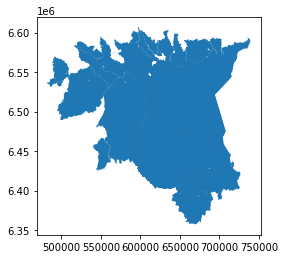

In [17]:
hydchem_catchs.plot()

In [25]:
hydchem_catchs

,kkr_kood,nimi,Shape_Area,geometry
0,SJA9316000,Pudisoo jõgi: Pudisoo,134.208450,"POLYGON ((585865.000 6587725.000, 585875.000 6..."
1,SJA6880000,Valgejõgi: Loksa jalakäijate sild,328.692975,"POLYGON ((597930.000 6606720.000, 597930.000 6..."
2,SJA8358000,Jänijõgi: Jäneda,39.670375,"POLYGON ((599250.000 6568615.000, 599250.000 6..."
3,SJA9895000,"Valgejõgi: Porkuni, Oruveski talust põhjasuunas",40.587025,"POLYGON ((629535.000 6566175.000, 629535.000 6..."
4,SJA6180000,Jägala jõgi: Jägala juga,1243.763600,"POLYGON ((578040.000 6568635.000, 578040.000 6..."
5,SJA2051000,Vihterpalu jõgi: Vihterpalu,475.863700,"POLYGON ((490395.000 6545470.000, 490395.000 6..."
6,SJA5960000,"Keila jõgi: suue, Keila-Joa",673.081825,"POLYGON ((517090.000 6584520.000, 517090.000 6..."
7,SJA6896000,Keila jõgi: Keila linn,635.699625,"POLYGON ((526760.000 6576810.000, 526760.000 6..."
8,SJA7837000,"Vääna jõgi: suue, Vääna-Jõesuu sild",310.042550,"POLYGON ((519990.000 6587175.000, 519995.000 6..."
9,SJA5140000,Pirita jõgi: Lükati sild,1938.188821,"POLYGON ((549660.000 6595390.000, 549660.000 6..."


In [ ]:
import tempfile
import shutil

per_catch_data = []

with tempfile.TemporaryDirectory() as tmpdirname:
    print('created temporary directory', tmpdirname)

    for idx, catch_row in hydchem_catchs.iterrows():
        
        try:
            with open(f"data/{catch_row['kkr_kood']}_response.json", encoding='utf-8') as file:
                testdata = json.load(file)[0]

                result_df = prep_csv_output(testdata, temp_dir=tmpdirname)
                # extract estimates of fluxes from returned json
                result_df_head = extract_from_the_top(result_df)
                # display(result_df_head)
                per_catch_data.append(result_df_head)
        except Exception as ex:
            print(catch_row)
            print(ex)

try:
    shutil.rmtree(tmpdirname)
    print('deleted temporary directory', tmpdirname)
except:
    print('Error while deleting directory')

In [28]:
est_model_data = pd.concat(per_catch_data, axis=0)
est_model_data.head(2)

,year,type,c_code,c_name,sc_code,sc_name,s_code,s_name,area,tn_measurement,tp_measurement,tn_estimate,tn_unadjusted_estimate,tn_adjustment,tp_estimate,tp_unadjusted_estimate,tp_adjustment
1,2019,subcatchment,SJA9316000,Pudisoo jõgi: Pudisoo,SJA9316000,Pudisoo jõgi: Pudisoo,NaN,NaN,136.8673,51100.543653,2874.516700,51100.543653,42011.522694,1.216461,2874.516700,1248.337731,2.303117
1,2019,subcatchment,SJA6880000,Valgejõgi: Loksa jalakäijate sild,SJA6880000,Valgejõgi: Loksa jalakäijate sild,NaN,NaN,345.6294,296967.081162,4719.775843,231709.728237,125448.239609,1.850553,4149.264423,3435.150577,1.208474


In [31]:
hyd_df = hydchem_catchs.merge(est_model_data, left_on="kkr_kood", right_on="sc_code", how="inner")
hyd_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 83 entries, 0 to 82
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   kkr_kood                83 non-null     object  
 1   nimi                    83 non-null     object  
 2   Shape_Area              83 non-null     float64 
 3   geometry                83 non-null     geometry
 4   year                    83 non-null     int64   
 5   type                    83 non-null     object  
 6   c_code                  83 non-null     object  
 7   c_name                  83 non-null     object  
 8   sc_code                 83 non-null     object  
 9   sc_name                 83 non-null     object  
 10  s_code                  0 non-null      object  
 11  s_name                  0 non-null      object  
 12  area                    83 non-null     float64 
 13  tn_measurement          83 non-null     float64 
 14  tp_measurement      

In [33]:
hyd_df.to_file(r"C:\dev\build\estmodel_sensitivity\misc\Hüdrokeemia_valglad_base_estmodel.gpkg", driver="GPKG", layer="estmodel_base_hydrochem_stations")

ERROR: collection.__init__(): PROJ: proj_as_wkt: Projected 3D CRS can only be exported since WKT2:2019
ERROR: collection.__init__(): PROJ: proj_as_wkt: Projected 3D CRS can only be exported since WKT2:2019
